In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import distributions as dist

import scipy.signal
import scipy.stats

from metropolis import acceptance_rate_per_step, conditional_prob, mala_step, lagk_ac

# General Setup

We have a target distribution and we will try to sample from it using Metropolis MCMC with various proposal distributions.

Some useful links were found here:  
http://www.mcmchandbook.net/HandbookChapter1.pdf  
https://theclevermachine.wordpress.com/2012/11/19/a-gentle-introduction-to-markov-chain-monte-carlo-mcmc/


Information on lag-k autocorrelation:
http://www.itl.nist.gov/div898/handbook/eda/section3/eda35c.htm

Given measurements, $Y_1, Y_2, ..., Y_N$ at time $X_1, X_2, ..., X_N$, the lag k autocorrelation function is defined as
\begin{equation}
    r_k = \frac{\sum_{i=1}^{N-k}(Y_{i} - \bar{Y})(Y_{i+k} - \bar{Y})}{\sum_{i=1}^{N}(Y_{i} - \bar{Y})^{2}}
\end{equation}

Check out:  
adaptaive metropolis  
rwm N(o,simga I) find simga  
deterministic schedule is unbiased, adaptive is bias  
autograd <- differentiation  

In [2]:
# Select bimodal
if False:
    mean1 = [2, 0]
    cov1 = [[1, 0], [0, 1]]

    mean2 = [-2, 0]
    cov2 = [[1, 0], [0, 1]]
    
    rv = dist.bimodal_dist(mean1, mean2, cov1, cov2)
    
    # Proposal distribution
    def proposal_dist_normal_2d(state, covar=[[0.75, 0], [0, 0.75]]):
        return scipy.stats.multivariate_normal(state, covar)
    
# Select parabolic gaussian
if False:
    mean = [0, 0]
    cov = [[1, 0], [0, 1]]

    rv = dist.parabolic_gaussian(mean, cov, warp=0.05)
    
    # Proposal distribution
    def proposal_dist_normal_2d(state, covar=[[0.5, 0], [0, 0.5]]):
        return scipy.stats.multivariate_normal(state, covar)

# Select streched gaussian
if True:
    mean = [0, 0]
    cov = [[1, 0], [0, 100]]
    
    rv = dist.stretched_normal(mean, cov)
    
    # Proposal distribution
    def proposal_dist_normal_2d(state, covar=[[1, 0], [0, 10]]):
        return scipy.stats.multivariate_normal(state, covar)

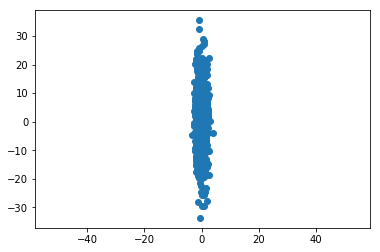

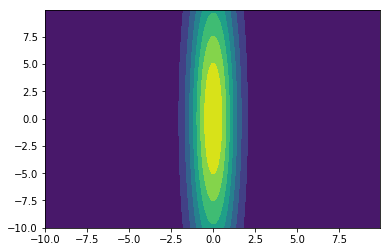

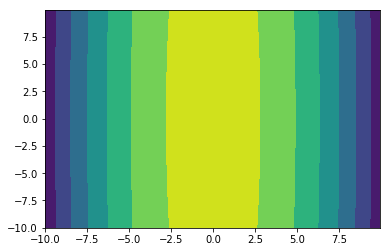

In [3]:
# Samples
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(*rv.rvs(1000).T, 'o')
ax1.axis('equal')
plt.show()

x, y = np.mgrid[-10:10:.1,
                -10:10:.1]
pos = np.dstack((x, y))

# pdf
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, rv.pdf(pos))
plt.show()

# logpdf
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.contourf(x, y, rv.logpdf(pos))
plt.show()

In [4]:
# Random Walk MCMC Function
def metropolis_step(state, proposal_dist, target_dist, v=False, log=False):
    proposed_state = state + proposal_dist.rvs()
    
    # Note that this is a metropolis algorithm because:
    # scipy.stats.multivariate_normal(state, covar).pdf(proposed_state) == 
    # scipy.stats.multivariate_normal(proposed_state, covar).pdf(state)
    
    if not log:
        acceptance_prob = min([1, target_dist.pdf(proposed_state)/target_dist.pdf(state)])

        if v:
            print(state, proposed_state, target_dist.pdf(proposed_state)/target_dist.pdf(state))

        if np.random.rand() <= acceptance_prob:
            return proposed_state
        else:
            return state
    else:
        acceptance_prob = min([0, target_dist.logpdf(proposed_state) - target_dist.logpdf(state)])

        if v:
            print(state, proposed_state, target_dist.logpdf(proposed_state) - target_dist.logpdf(state))

        if np.log(np.random.rand()) <= acceptance_prob:
            return proposed_state
        else:
            return state

In [5]:
# MCMC Execution
states = [np.array([0,0])]
steps = 1000

proposal_dist = scipy.stats.multivariate_normal([0,0], 0.2 * np.asarray([[1,0],[0,0.05]]))

for i in range(steps):
    states.append(metropolis_step(states[-1], proposal_dist, rv, v=False, log=True))
    
states = np.asarray(states)

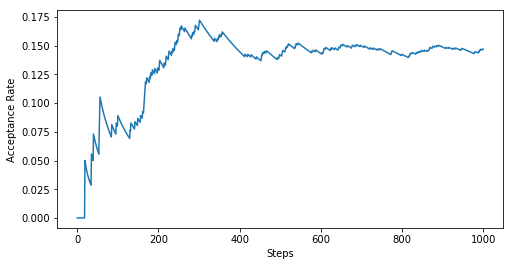

In [6]:
# Acceptance rate plot
acps = acceptance_rate_per_step(states)
plt.figure(figsize=(8, 4))
plt.plot(range(steps ), acps)
plt.xlabel('Steps')
plt.ylabel('Acceptance Rate')
plt.show()

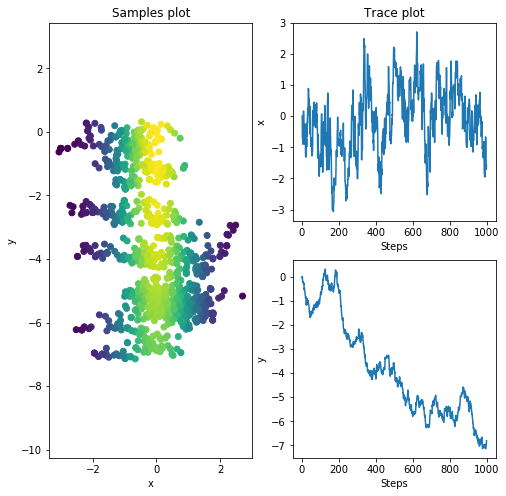

In [7]:
# Sample and trace plots
df = pd.DataFrame(states, columns=["x", "y"])

plt.figure(1, figsize=(8,8))
plt.subplot(121)
plt.scatter(df.x, df.y, c=rv.pdf(states))
plt.axis('equal')
plt.title('Samples plot')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(222)
plt.plot(np.arange(states.shape[0]), df.x)
plt.title('Trace plot')
plt.xlabel('Steps')
plt.ylabel('x')

plt.subplot(224)
plt.plot(np.arange(states.shape[0]), df.y)
plt.xlabel('Steps')
plt.ylabel('y')

plt.show()

C:\Users\Kurt Sinodaur\PycharmProjects\mcmc\metropolis.py:24: RuntimeWarning: invalid value encountered in true_divide
  return np.divide(nom, denom)


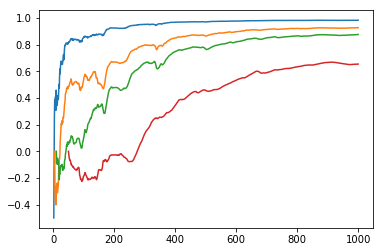

In [9]:
def lag_line(sequence, k):
    plot_ac = []
    variance = np.sum(np.dot(sequence - np.mean(sequence, axis=0), (sequence - np.mean(sequence, axis=0)).T).diagonal())

    for i in range(len(sequence)):
        if i < k:
            pass
        else:
            plot_ac.append([i, lagk_ac(sequence[:i], k, v=False, variance=None)])
    return np.asarray(plot_ac)

lag1 = lag_line(states, 1)
lag5 = lag_line(states, 5)
lag10 = lag_line(states, 10)
lag50 = lag_line(states, 50)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(lag1[:,0], lag1[:,1])
ax.plot(lag5[:,0], lag5[:,1])
ax.plot(lag10[:,0], lag10[:,1])
ax.plot(lag50[:,0], lag50[:,1])
plt.show()